## BIOINF575-final: KEGG pathways overlap

Division: we divide the trasks and profread the work

1. setup

In [1]:
#Setup: deps, paths, helpers

import os, re, json, itertools as it
import pandas as pd
import requests

OUTDIR = "/Users/mandy/Downloads/bioinfo575_final/output"
RAWDIR = "/Users/mandy/Downloads/bioinfo575_final/kegg_raw"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(RAWDIR, exist_ok=True)

KEGG_DOC = "https://www.kegg.jp/kegg/rest/keggapi.html"
ENDPOINTS = {
    "pathways_hsa": "https://rest.kegg.jp/list/pathway/hsa",
    "link_gene_pathway": "https://rest.kegg.jp/link/pathway/hsa",
    "genes_hsa": "https://rest.kegg.jp/list/hsa",
}
UA_HEADERS = {"User-Agent": "curl/8.4.0", "Accept": "text/plain"}

def fetch_tsv(url: str, raw_save_path: str, timeout: int = 60):
    r = requests.get(url, headers=UA_HEADERS, allow_redirects=True, timeout=timeout)
    r.raise_for_status()
    text = r.text
    with open(raw_save_path, "w", encoding="utf-8") as f:
        f.write(text)
    lines = [ln for ln in text.splitlines() if ln.strip()]
    if sum("\t" in ln for ln in lines) == 0:
        raise RuntimeError(f"Non-TSV response for {url}; saved to: {raw_save_path}")
    return lines


2. step1: Map/merge the information by PATHWAY_ID and GENE_ID

In [2]:
#Step 1: Map/Merge by PATHWAY_ID & GENE_ID
pathways_lines = fetch_tsv(ENDPOINTS["pathways_hsa"], f"{RAWDIR}/pathways_hsa.tsv")
links_lines    = fetch_tsv(ENDPOINTS["link_gene_pathway"], f"{RAWDIR}/link_pathway_hsa.tsv")
genes_lines    = fetch_tsv(ENDPOINTS["genes_hsa"], f"{RAWDIR}/genes_hsa.tsv")

pid2name = {}
for ln in pathways_lines:
    if "\t" not in ln:
        continue
    pid, pname = ln.split("\t", 1)
    pid = pid.replace("path:", "").strip()
    pid2name[pid] = pname.strip()

gid2sym = {}
for ln in genes_lines:
    if "\t" not in ln:
        continue
    parts = ln.split("\t")
    gid = parts[0].strip()
    name_block = parts[-1].strip()
    import re as _re
    sym = _re.split(r"[;,]", name_block, maxsplit=1)[0].strip()
    if sym:
        gid2sym[gid] = sym

pairs = []
for ln in links_lines:
    if "\t" not in ln:
        continue
    gid, pid = ln.split("\t", 1)
    pid = pid.replace("path:", "").strip()
    pairs.append((gid.strip(), pid))

rows = []
for gid, pid in pairs:
    if pid in pid2name and gid in gid2sym:
        rows.append({
            "GENE_ID": gid,
            "GENE_SYMBOL": gid2sym[gid],
            "PATHWAY_ID": pid,
            "PATHWAY_NAME": pid2name[pid]
        })
df_map = pd.DataFrame(rows, columns=["GENE_ID","GENE_SYMBOL","PATHWAY_ID","PATHWAY_NAME"])
df_map.sort_values(["PATHWAY_ID","GENE_SYMBOL","GENE_ID"], inplace=True)
step1_path = f"{OUTDIR}/step1_gene_pathway_map.csv"
df_map.to_csv(step1_path, index=False)

summary1 = {
    "n_pathways_total": len(pid2name),
    "n_links": len(links_lines),
    "n_genes_total": len(gid2sym),
    "n_rows_in_map": len(df_map),
    "doc": KEGG_DOC,
    "endpoints": ENDPOINTS,
}
with open(f"{OUTDIR}/step1_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary1, f, ensure_ascii=False, indent=2)

{'step1_map_file': step1_path, 'rows': len(df_map)}


{'step1_map_file': '/Users/mandy/Downloads/bioinfo575_final/output/step1_gene_pathway_map.csv',
 'rows': 39704}

3. step2: compute the number of overlapping genes between every 2 pathways
& step3: create KEGG_crosstalk.csv 

In [7]:
#Step 2: Compute overlap counts for every 2 pathways
from collections import defaultdict
#build pathway_id - gene symbols dictionary
p2syms = defaultdict(set)
for _, row in df_map.iterrows():
    p2syms[row["PATHWAY_ID"]].add(row["GENE_SYMBOL"])

#build pathway_id -> pathway_name from prrevious map
pid2name = {}
for _, row in df_map.iterrows():
    pid2name[row["PATHWAY_ID"]] = row["PATHWAY_NAME"]

#sort pathway_ids include at least one gene symbol
pids = sorted([pid for pid, syms in p2syms.items() if len(syms) > 0])
#compute overlap counts
KEGG_crosstalk = []
for i in range(len(pids)):
    for j in range(i+1, len(pids)):
        pid1, pid2 = pids[i], pids[j]
        #find overlapping genes
        overlap = p2syms[pid1] & p2syms[pid2]
        count = len(overlap)
        if count >0:
            KEGG_crosstalk.append({
                "PATHWAY_ID1":pid1,
                "PATHWAY_NAME1":pid2name[pid1],
                "PATHWAY_ID2":pid2,
                "PATHWAY_NAME2":pid2name[pid2],
                "OVERLAP_COUNT": count,
                "OVERLAP_GENES": ";".join(sorted(overlap))
            })

#export to csv
df_crosstalk = pd.DataFrame(KEGG_crosstalk)
df_crosstalk.sort_values("OVERLAP_COUNT", ascending=False, inplace=True)

#save to KEGG_crosstalk.csv
crosstalk_file = f"{OUTDIR}/KEGG_crosstalk.csv"
df_crosstalk.to_csv(crosstalk_file, index=False)

4. step4: compute a rank of the genes based on how many pathways they appear on and save it to a file

In [ ]:
from collections import Counter
import re

#count how many pathways each gene appears in
pathway_counts = Counter()
for _, row in df_map.iterrows():
    pathway_counts[row["GENE_SYMBOL"]] += 1

#filter for standard gene symbols
valid_gene_pattern = re.compile(r'^[A-Z][A-Z0-9]*$')
#map genes with their pathway counts
gene_ranks = []
for gene_symbol, pathway_count in pathway_counts.items():
    #filter out ribosomal RNA and other non-standard gene symbols
    if (not any(keyword in gene_symbol.lower() for keyword in 
                ['ribosomal', 'rna', 'rrna', 'trna', 'mirna', 'snrna', 'snorna']) 
        and valid_gene_pattern.match(gene_symbol)
        and len(gene_symbol) > 1):  
        gene_ranks.append({
            "GENE_SYMBOL": gene_symbol,
            "NUMBER_PATHWAYS": pathway_count
        })

#reorganize in descending order
df_gene_ranks = pd.DataFrame(gene_ranks)
df_gene_ranks.sort_values("NUMBER_PATHWAYS", ascending=False, inplace=True)

#add the rank
df_gene_ranks["RANK"] = range(1, len(df_gene_ranks) + 1)
df_gene_ranks = df_gene_ranks[["RANK", "GENE_SYMBOL", "NUMBER_PATHWAYS"]]

gene_rank_filtered = f"{OUTDIR}/gene_rank_based_pathway_counts_filtered.csv"
df_gene_ranks.to_csv(gene_rank_filtered, index=False)

I have to filter out the standard gene symbols, otherwise the top would be noncoding genes, and has less pathways in common

5. step5: retrieve a set of the common pathways of the top 4/3 genes

In [5]:
top_4_genes = df_gene_ranks.head(4)["GENE_SYMBOL"].tolist()

#build gene_symbol - pathway_ids dictionary
gene_pathways = defaultdict(set)
for _, row in df_map.iterrows():
    gene_pathways[row["GENE_SYMBOL"]].add(row["PATHWAY_ID"])

#find common pathways for top 4 genes
common_pathways_top4 = set(gene_pathways[top_4_genes[0]])
#use intersection
for gene in top_4_genes[1:]:
    common_pathways_top4 &= gene_pathways[gene]

In [39]:
print(len(common_pathways_top4))

85


since there are common pathways for top 4 genes, so we won't try the top 3

In [40]:
common_pathways = common_pathways_top4
genes_used = top_4_genes

#export results
common_pathways_result = {
    "genes_analyzed": genes_used,
    "number_of_genes": len(genes_used),
    "common_pathways_count": len(common_pathways),
    "common_pathway_ids": sorted(list(common_pathways)),
    "common_pathway_details": [
        {"pathway_id": pid, "pathway_name": pid2name.get(pid, "Unknown")}
        for pid in sorted(common_pathways)
    ]
}

df_common_pathways = pd.DataFrame(common_pathways_result["common_pathway_details"])
common_pathways_csv = f"{OUTDIR}/top_4_genes_common_pathways.csv"
df_common_pathways.to_csv(common_pathways_csv, index=False)


6. step6: use Venn diagram to visualizing overlapping pathways for the top 4 genes

In [41]:
import matplotlib.pyplot as plt
gene_to_pathways = defaultdict(set)
for _, row in df_map.iterrows():
    gene_to_pathways[row["GENE_SYMBOL"]].add(row["PATHWAY_ID"])
top_4_genes = df_gene_ranks.head(4)["GENE_SYMBOL"].tolist()

#check top four genes and their pathway numbers
for gene in top_4_genes:
    count = df_gene_ranks[df_gene_ranks["GENE_SYMBOL"] == gene]["NUMBER_PATHWAYS"].iloc[0]
    print(f"  {gene}: {count} pathways")

  MAPK3: 119 pathways
  MAPK1: 119 pathways
  PIK3CD: 108 pathways
  PIK3CB: 108 pathways


In [42]:
print(gene_to_pathways[top_4_genes[0]])

{'hsa04611', 'hsa04650', 'hsa04730', 'hsa05211', 'hsa04935', 'hsa01524', 'hsa04657', 'hsa04919', 'hsa04148', 'hsa04140', 'hsa04713', 'hsa04072', 'hsa04150', 'hsa04910', 'hsa04371', 'hsa04666', 'hsa05213', 'hsa04517', 'hsa05221', 'hsa04540', 'hsa04930', 'hsa05200', 'hsa04510', 'hsa05224', 'hsa04621', 'hsa04722', 'hsa05206', 'hsa05215', 'hsa04520', 'hsa04022', 'hsa05218', 'hsa04024', 'hsa05219', 'hsa05207', 'hsa04550', 'hsa04114', 'hsa04659', 'hsa05133', 'hsa04929', 'hsa05212', 'hsa05010', 'hsa04664', 'hsa05167', 'hsa05020', 'hsa05130', 'hsa05203', 'hsa04917', 'hsa04613', 'hsa04915', 'hsa04270', 'hsa04810', 'hsa05208', 'hsa04658', 'hsa04934', 'hsa04210', 'hsa01521', 'hsa05131', 'hsa05170', 'hsa05210', 'hsa04725', 'hsa04668', 'hsa04261', 'hsa05145', 'hsa04912', 'hsa05226', 'hsa05230', 'hsa05166', 'hsa05223', 'hsa05022', 'hsa04380', 'hsa04720', 'hsa04723', 'hsa04724', 'hsa04012', 'hsa04620', 'hsa04921', 'hsa05165', 'hsa05225', 'hsa04933', 'hsa05220', 'hsa05205', 'hsa05231', 'hsa04625', 'hs

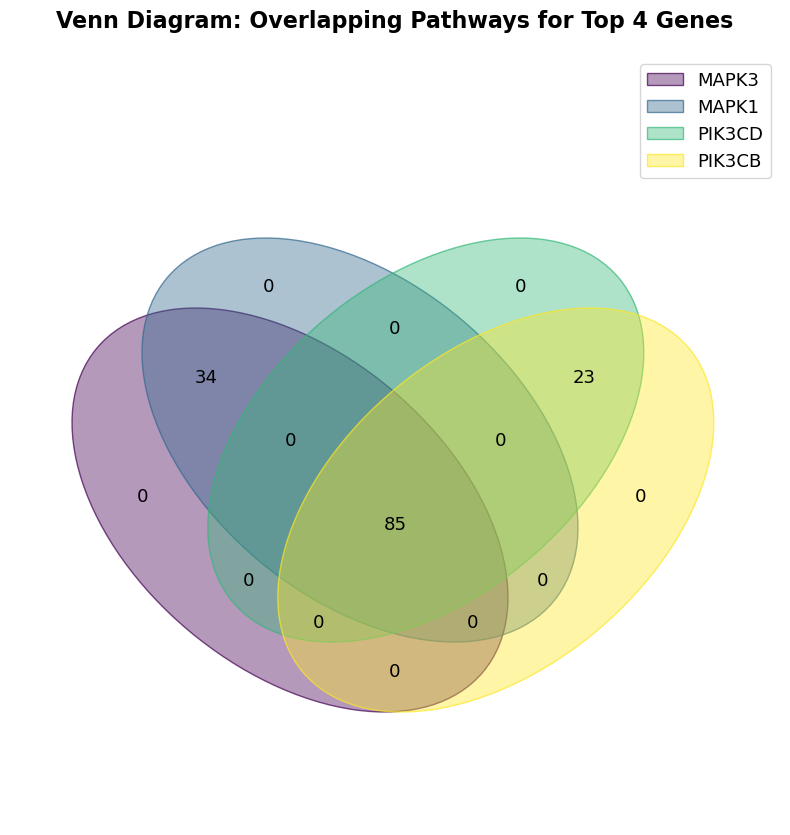

In [43]:
#use pyvenn to creat 4 sets venn plots
fig, ax = plt.subplots(figsize=(12, 10))
venn_data = {gene: gene_to_pathways[gene] for gene in top_4_genes}
venn(venn_data, ax=ax)

#title
plt.title('Venn Diagram: Overlapping Pathways for Top 4 Genes', 
          fontsize=16, fontweight='bold', pad=20)

venn_file = f"{OUTDIR}/venn_diagram_top4_genes.png"
plt.savefig(venn_file, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

It's time to explore some new features!!

a. top 3 pathways with the highest number of genes

In [ ]:
import pandas as pd

In [3]:
#read the csv file
pd = pd.read_csv("/Users/mandy/Downloads/bioinfo575_final/output/step1_gene_pathway_map.csv")

In [5]:
#count unique genes per pathway
pathway_counts = pd.groupby(['PATHWAY_ID', 'PATHWAY_NAME'])['GENE_SYMBOL'].nunique().reset_index()
pathway_counts.columns = ['PATHWAY_ID', 'PATHWAY_NAME', 'NUMBER_OF_GENES']

#sort by gene count in descending order
pathway_counts = pathway_counts.sort_values('NUMBER_OF_GENES', ascending=False).reset_index(drop=True)
pathway_counts.head(3)

,PATHWAY_ID,PATHWAY_NAME,NUMBER_OF_GENES
0,hsa01100,Metabolic pathways - Homo sapiens (human),1579
1,hsa05200,Pathways in cancer - Homo sapiens (human),533
2,hsa05022,Pathways of neurodegeneration - multiple disea...,481


Metabolic pathway is the most comprehensive one, which contains nearly 3 times more genes than the pathways in cancer.

In [8]:
output_path = "/Users/mandy/Downloads/bioinfo575_final/output/pathway_gene_counts.csv"
pathway_counts.to_csv(output_path, index=False)

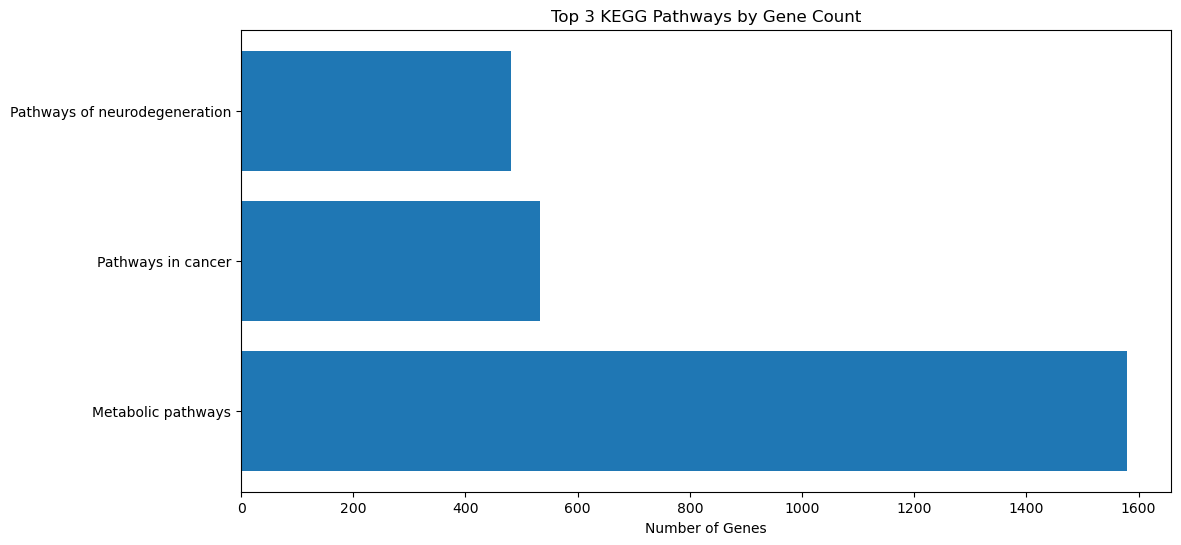

In [10]:
import matplotlib.pyplot as plt

top3 = pathway_counts.head(3)

plt.figure(figsize=(12, 6))
plt.barh(range(len(top3)), top3['NUMBER_OF_GENES'])
plt.yticks(range(len(top3)), [name.split(' - ')[0] if ' - ' in name else name 
                                 for name in top3['PATHWAY_NAME']])
plt.xlabel('Number of Genes')
plt.title('Top 3 KEGG Pathways by Gene Count')

plt.savefig('/Users/mandy/Downloads/bioinfo575_final/output/top3_pathways.png', dpi=300)
plt.show()